In [2]:
import sys
import time
import warnings

#!{sys.executable} -m pip install unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pre-processing
import re
import unidecode
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
train_data1 = pd.read_csv('dataset1/X_train.csv')
train_data2 = pd.read_csv('dataset2/X_train.csv')
train_data3 = pd.read_csv('dataset3/X_train.csv')
train_data4 = pd.read_csv('dataset4/X_train.csv')
train_data5 = pd.read_csv('dataset5/X_train.csv')
train_data6 = pd.read_csv('dataset6/X_train.csv')
train_data7 = pd.read_csv('dataset7/X_train.csv')
train_data8 = pd.read_csv('dataset8/X_train.csv')
train_data9 = pd.read_csv('dataset9/X_train.csv')

train_data_final = pd.concat([train_data1,train_data2,train_data3,train_data4,train_data5,train_data6,train_data7,train_data8,train_data9], axis=0)
train_data_final.head()

,Unnamed: 0,Id,title,source URL,body,time,keywords,country,data source,language
0,1395,FL-2019-000179-CAN,Canada: extreme floods show climate threat as ...,https://www.theguardian.com/world/2019/apr/30/...,News footage showed people boating where they ...,2019-04-30 07:00:00+00:00,"['change', 'water', 'warn', 'threat', 'quebec'...",Canada,news article,English
1,42,DR-2014-000109-CHN,Celebrating The Work Of Robin Williams | Here ...,https://www.wbur.org/hereandnow/2014/08/12/cel...,Comedy star Robin Williams died yesterday at a...,2014-08-12 07:00:00+00:00,"['vietnam', 'tv', 'yesterday', 'robin', 'willi...",China,news article,English
2,1779,FL-2021-000030-IDN,Innovative technologies to combat flooding in ...,https://uk.news.yahoo.com/innovative-technolog...,Innovative technologies involving flood alert ...,2021-03-28 07:00:00+00:00,"['england', 'projects', 'communities', 'coasta...",India,news article,English
3,941,DR-2011-000121-CHN,Book review: 'Grand Pursuit' by Sylvia Nasar -...,https://www.latimes.com/books/la-xpm-2011-sep-...,Grand Pursuit\n\nThe Story of Economic Genius\...,2011-09-11 07:00:00+00:00,"['review', 'economic', 'pursuit', 'keynes', 't...",China,news article,English
4,2048,FL-2017-000017-PAK,"Record Rains, Urban Flooding Woes Continue in ...",https://www.voanews.com/south-central-asia/rec...,ISLAMABAD - Parts of Pakistan's commercial hub...,2020-08-31 07:00:00+00:00,"['woes', 'rains', 'city', 'problems', 'local',...",Pakistan,news article,English


In [4]:
train_data_final.shape

(1206, 10)

In [5]:
train_labels1 = pd.read_csv('dataset1/y_train.csv')
train_labels2 = pd.read_csv('dataset2/y_train.csv')
train_labels3 = pd.read_csv('dataset3/y_train.csv')
train_labels4 = pd.read_csv('dataset4/y_train.csv')
train_labels5 = pd.read_csv('dataset5/y_train.csv')
train_labels6 = pd.read_csv('dataset6/y_train.csv')
train_labels7 = pd.read_csv('dataset7/y_train.csv')
train_labels8 = pd.read_csv('dataset8/y_train.csv')
train_labels9 = pd.read_csv('dataset9/y_train.csv')

train_labels = pd.concat([train_labels1,train_labels2,train_labels3,train_labels4,train_labels5,train_labels6,train_labels7,train_labels8,train_labels9],axis=0)
print(train_labels.shape)
train_labels.head()


(1206, 2)


,Unnamed: 0,category
0,1395,flood
1,42,none
2,1779,flood
3,941,none
4,2048,flood


In [6]:
train_data_final['final'] = train_data_final['title'] + ' ' + train_data_final['body'] 
train_data = train_data_final[['final']]

In [7]:
train_labels['category'].value_counts()

none     621
flood    585
Name: category, dtype: int64

In [8]:
import re
from tqdm import tqdm
def preprocess(article):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the article
    text = article.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(article) for article in tqdm(train_data['final'])]

100%|██████████| 1206/1206 [00:00<00:00, 3384.05it/s]


In [10]:
from collections import Counter
counts = dict(Counter(word for sentence in preprocessed for word in sentence.split()))
{k: counts[k] for k in list(counts)[:10]}

{'canada': 279,
 'extreme': 217,
 'floods': 1636,
 'show': 163,
 'climate': 1080,
 'threat': 120,
 'as': 4612,
 'experts': 135,
 'warn': 44,
 'of': 23444}

In [11]:
data_test1 = pd.read_csv('dataset1/X_test.csv')
data_test2 = pd.read_csv('dataset2/X_test.csv')
data_test3 = pd.read_csv('dataset3/X_test.csv')
data_test4 = pd.read_csv('dataset4/X_test.csv')
data_test5 = pd.read_csv('dataset5/X_test.csv')
data_test6 = pd.read_csv('dataset6/X_test.csv')
data_test7 = pd.read_csv('dataset7/X_test.csv')
data_test8 = pd.read_csv('dataset8/X_test.csv')
data_test9 = pd.read_csv('dataset9/X_test.csv')

data_test_final = pd.concat([data_test1,data_test2,data_test3,data_test4,data_test5,data_test6,data_test7,data_test8,data_test9], axis=0)

data_test = data_test_final['title'] + ' ' + data_test_final['body']
data_test = [preprocess(article) for article in tqdm(data_test)]

test_labels1 = pd.read_csv('dataset1/y_test.csv')
test_labels2 = pd.read_csv('dataset2/y_test.csv')
test_labels3 = pd.read_csv('dataset3/y_test.csv')
test_labels4 = pd.read_csv('dataset4/y_test.csv')
test_labels5 = pd.read_csv('dataset5/y_test.csv')
test_labels6 = pd.read_csv('dataset6/y_test.csv')
test_labels7 = pd.read_csv('dataset7/y_test.csv')
test_labels8 = pd.read_csv('dataset8/y_test.csv')
test_labels9 = pd.read_csv('dataset9/y_test.csv')

test_labels = pd.concat([test_labels1,test_labels2,test_labels3,test_labels4,test_labels5,test_labels6,test_labels7,test_labels8,test_labels9],axis=0)


100%|██████████| 594/594 [00:00<00:00, 3357.40it/s]


In [ ]:
train_data_final.to_csv('train_data.csv',index=False)
train_labels.to_csv('train_labels.csv',index=False)
data_test_final.to_csv('test_data.csv',index=False)
test_labels.to_csv('test_labels.csv',index=False)

In [12]:
embed_size = 300 # how big is each word vector
max_features = 35000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a content to use

In [13]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(preprocessed)
train_X = tokenizer.texts_to_sequences(preprocessed)
test_X = tokenizer.texts_to_sequences(data_test)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
train_y = le.fit_transform(train_labels['category'].values)
test_y = le.transform(test_labels['category'].values)
len(le.classes_)

2

In [14]:
len(tokenizer.word_index)

35086

In [17]:
import pickle
with open("tokenizer_v1_2.pkl", 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_encoder_v1_2.pkl", 'wb') as file:
    pickle.dump(le, file, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
debug = 0
def load_glove(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    del embeddings_index['PN']
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

if debug:
    embedding_matrix = np.random.randn(max_features,embed_size)
else:
    embedding_matrix = load_glove(tokenizer.word_index)
np.shape(embedding_matrix)

/Users/askani.mohankrishna/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(35000, 300)

In [19]:
import numpy as np
np.save('embedding_matrix_v1_2.npy' , embedding_matrix)

In [16]:
train_X1 = train_X[:2]

#Paste num in self.extra_features below 
train_X1.shape[1] - maxlen

0

In [17]:
class BiLSTM(nn.Module): 
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size_1 = 64
        self.hidden_size_2 = 64
        self.extra_features = 0
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size_1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size_1*4 + self.extra_features, self.hidden_size_2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size_2, n_classes)

    def forward(self, x):
        input = x[:,:maxlen]
        of = x[:,maxlen:]
        
        h_embedding = self.embedding(input)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool, of), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [18]:
model = BiLSTM()

x = torch.tensor(train_X1, dtype=torch.long)
model.forward(x).detach().numpy().shape

(2, 2)

In [19]:
n_epochs = 7
batch_size = 30


model = BiLSTM()

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)#.cuda()
y_train = torch.tensor(train_y, dtype=torch.long)#.cuda()

x_cv = torch.tensor(test_X, dtype=torch.long)#.cuda()
y_cv = torch.tensor(test_y, dtype=torch.long)#.cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    
    

<ipython-input-19-3c42e3ed9b37>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()


Epoch 1/7 	 loss=19.4692 	 val_loss=19.1280  	 val_acc=0.5455  	 time=20.06s
Epoch 2/7 	 loss=14.4061 	 val_loss=10.6973  	 val_acc=0.8384  	 time=19.69s
Epoch 3/7 	 loss=10.0854 	 val_loss=9.6520  	 val_acc=0.8670  	 time=18.75s
Epoch 4/7 	 loss=8.5687 	 val_loss=9.0691  	 val_acc=0.8822  	 time=19.65s
Epoch 5/7 	 loss=6.7908 	 val_loss=8.6780  	 val_acc=0.8838  	 time=19.47s
Epoch 6/7 	 loss=4.6496 	 val_loss=9.3508  	 val_acc=0.8754  	 time=18.99s
Epoch 7/7 	 loss=2.7443 	 val_loss=9.5439  	 val_acc=0.8754  	 time=18.96s


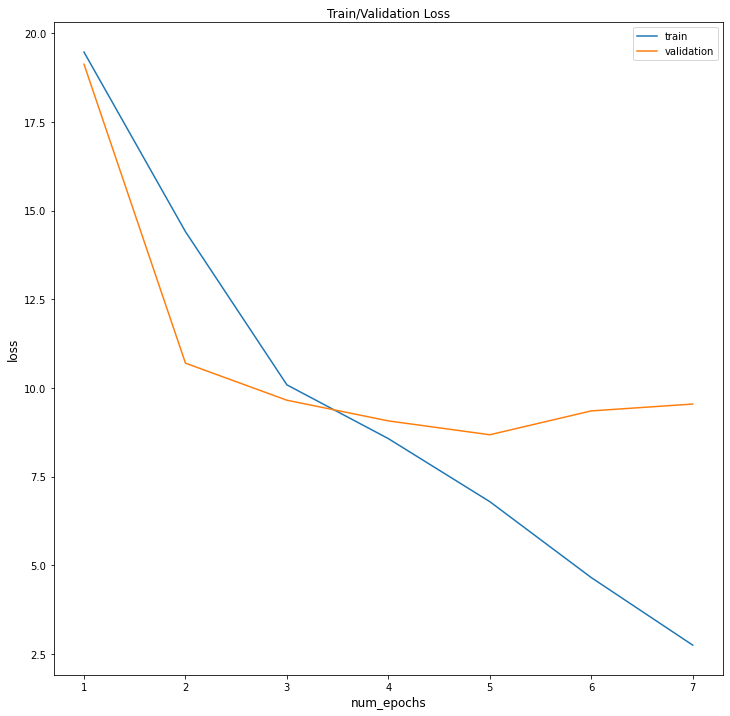

In [20]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

In [21]:
pred = le.inverse_transform(val_preds.argmax(axis=1))
test = le.inverse_transform(test_y)
from sklearn.metrics import classification_report
print(classification_report(test,pred,labels=train_labels['category'].unique()))

              precision    recall  f1-score   support

       flood       0.86      0.92      0.89       315
        none       0.90      0.82      0.86       279

    accuracy                           0.88       594
   macro avg       0.88      0.87      0.87       594
weighted avg       0.88      0.88      0.87       594



In [22]:
filename = 'model_newsclassifier_v1_2.pt'
torch.save(model.state_dict(), filename)